In [42]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy import stats
import statsmodels.api as sm
from itertools import product
from scipy.ndimage import gaussian_filter
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [43]:
analysis_df = pd.read_csv('data/total_analysis_df.csv')
analysis_df['Date'] = pd.to_datetime(analysis_df['Date'])
analysis_df = analysis_df.set_index('Date')
analysis_df.head()

,Confirmed_new_US,Deaths_new_US,retail_US,retail_US_diff,grocery_US,grocery_US_diff,parks_US,parks_US_diff,transit_google_US,transit_google_US_diff,...,sbj18_count_weighted,sbj18_favourites_weighted,sbj18_retweet_weighted,sbj18_popularity_weighted,sbj18_engagement_weighted,sbj19_count_weighted,sbj19_favourites_weighted,sbj19_retweet_weighted,sbj19_popularity_weighted,sbj19_engagement_weighted
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-12,393.0,4.0,10.019729,0.298444,22.720821,11.653862,27.285120,-7.292266,3.783693,-0.742964,...,30.366361,514516.320753,45.712579,517724.963144,783.021048,27.048881,517553.563224,32.312411,519821.625393,539.441568
2020-03-13,565.0,8.0,4.074367,-5.945362,25.283834,2.563012,12.217885,-15.067236,-0.098021,-3.881714,...,51.415687,836270.520446,48.754029,839692.647253,968.619367,59.714706,798435.590596,48.365220,801830.426310,1060.201632
2020-03-14,662.0,7.0,-2.160826,-6.235193,18.225341,-7.058493,12.997491,0.779606,-1.399180,-1.301159,...,30.026926,412672.078334,35.293293,415149.373605,498.918563,33.665548,952106.469811,54.937148,955962.600118,529.734021
2020-03-15,676.0,6.0,-2.062134,0.098692,16.525736,-1.699605,17.774478,4.776987,-2.441142,-1.041962,...,34.589109,614574.186140,39.893033,617374.344831,511.806045,37.896720,675710.595514,45.739917,678921.156824,733.813344
2020-03-16,872.0,14.0,-1.841855,0.220279,24.997330,8.471594,8.546993,-9.227485,-7.109609,-4.668467,...,41.989440,500040.190409,36.960089,502634.480863,650.507595,39.237705,546805.424915,39.925328,549607.850484,705.573526


In [44]:
covid_columns = ['Confirmed_new_US', 'Deaths_new_US']
mobility_columns = [col for col in analysis_df.columns if 'US' in col and col not in covid_columns and 'diff' not in col]
cluster_titles = ['home', 'sanitisers', 'isolation', 'distance', 'family', 'masks', 'washhands', 'workhome', 'health', 'total']
metrics = ['_count', '_popularity']
cluster_columns = ['cluster_' + title + metric for title in cluster_titles for metric in metrics]
sbjs = ['sbj' + str(i) for i in range(20)]
sbjs10 = ['sbj' + str(i) for i in range(10)]
sbjs20 = ['sbj' + str(i) for i in range(10, 20)]
clusts = ['clust' + str(i) for i in range(5)]
sbj_columns = [title + metric for title in sbjs for metric in metrics]
sbj10_columns = [title + metric for title in sbjs10 for metric in metrics]
sbj20_columns = [title + metric for title in sbjs20 for metric in metrics]
clust_columns = [title + metric for title in clusts for metric in metrics]
metrics = ['_count_weighted', '_favourites_weighted', '_retweet_weighted', '_popularity_weighted', '_engagement_weighted']
weighted_sbj_columns = [title + metric for title in sbjs for metric in metrics]

In [45]:
stable_analysis_df = analysis_df.loc[(analysis_df.index > '2020-03-19') & (analysis_df.index < '2020-05-01')]

In [47]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 3)

In [48]:
# TOPIC 0 - LOCAL GOVERNMENT

In [119]:
test_size = 4
# variable_title = 'sbj11_engagement_weighted'
variable_title = 'sbj0_engagement_weighted'

variable = stable_analysis_df[variable_title]
# exog_titles = ['Confirmed_new_US', 'Deaths_new_US', 'work_US', 'transit_google_US']
exog_titles = ['Confirmed_new_US', 'Deaths_new_US', 'transit_apple_US', 'transit_google_US', 'work_US', 'grocery_US']
exog = stable_analysis_df[exog_titles]

In [120]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(variable)[1])
print("Student test: p=%f" % stats.ttest_1samp(variable, 0)[1])

Dickey-Fuller test: p=0.073349
Student test: p=0.000000


In [121]:
dates_index = variable.index
variable_sub = pd.Series(gaussian_filter(variable, sigma=1)).to_frame().set_index([dates_index])[0]

train, test_data = variable_sub[0:len(variable_sub)-test_size], variable_sub[len(variable_sub)-test_size:]

exog_train = exog[:len(exog) - test_size]
exog_test = exog[len(exog) - test_size:]

In [52]:
# LOCAL GOVERNMENT 0 WITH EXOG TRAIN

ps = range(0, 5)
ds  = range(0, 2)
qs = range(0, 5)

parameters = product(ps, ds, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model = ARIMA(train.values, order=(param[0], param[1], param[2]), exog=exog_train).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 50
  parameters         aic
8  (1, 1, 4)  372.198193
7  (1, 1, 3)  379.122297
6  (0, 1, 4)  383.327933
5  (0, 1, 3)  390.744680
4  (0, 1, 1)  394.626715


In [122]:
# LOCAL GOVERNMENT 0 WITH EXOG TEST

# best_param = (1, 1, 4)
best_param = (2, 1, 1)
model_fit=ARIMA(train.values, order=(best_param[0], best_param[1], best_param[2]), exog=exog_train).fit()
forecast = model_fit.forecast(steps=test_size, exog=exog_test)
predictions_1 = list(forecast)[0]
train_with_predicted = list(train)
for i in predictions_1:
    train_with_predicted.append(i)

test_lag = len(test_data)
test_real = test_data
for j in range(1, len(test_data) + 1):
        test_lag = j
        t_mape = mape(test_data[:test_lag], predictions_1[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 3.2730000
For 2 days prediction Test MAPE: 2.6260000
For 3 days prediction Test MAPE: 6.0680000
For 4 days prediction Test MAPE: 12.1750000


In [54]:
# LOCAL GOVERNMENT 0 WITHOUT EXOG TRAIN

ps = range(0, 5)
ds  = range(0, 2)
qs = range(0, 5)

parameters = product(ps, ds, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model = ARIMA(train.values, order=(param[0], param[1], param[2])).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 50
  parameters         aic
6  (1, 1, 4)  381.222437
5  (0, 1, 2)  381.573092
4  (0, 1, 1)  394.667084
3  (0, 1, 0)  426.085062
2  (0, 0, 4)  433.465960


In [123]:
# LOCAL GOVERNMENT 0 WITHOUT EXOG TEST

# best_param = (1, 1, 4)
best_param = (2, 1, 1)
model_fit=ARIMA(train.values, order=(best_param[0], best_param[1], best_param[2])).fit()
forecast = model_fit.forecast(steps=test_size)
predictions_2 = list(forecast)[0]
train_with_predicted = list(train)
for i in predictions_2:
    train_with_predicted.append(i)

test_lag = len(test_data)
test_real = test_data
for j in range(1, len(test_data) + 1):
        test_lag = j
        t_mape = mape(test_data[:test_lag], predictions_2[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 8.1770000
For 2 days prediction Test MAPE: 11.9980000
For 3 days prediction Test MAPE: 12.0690000
For 4 days prediction Test MAPE: 10.5250000


In [124]:
# PREPARE FOR PLOT LOCAL GOVERNMENT 0 WITH/WITHOUT EXOG LISTS

last_value = list(train)[len(train) - 1]
test_list = list(test_data)
test_list.insert(0, last_value)
predictions_1=np.insert(predictions_1,0,last_value)
predictions_2=np.insert(predictions_2,0,last_value)
new_index = pd.Index([train.index[-1]]).append(test_data.index)

In [57]:
test_list

[467.93967922367835,
 485.7031878079571,
 482.90050865145247,
 442.8304581570984,
 352.3932231050763]

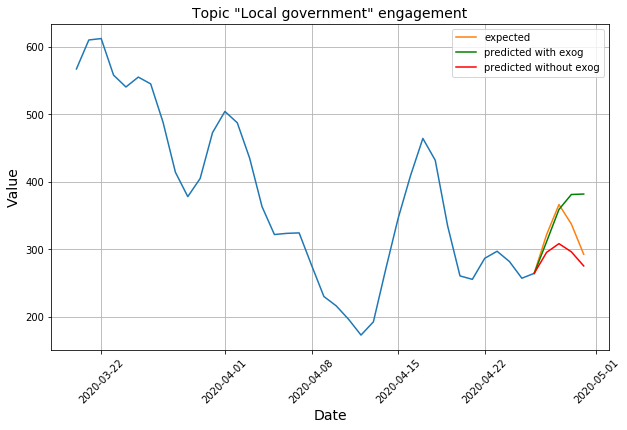

In [126]:
# PLOT LOCAL GOVERNMENT 0 WITH/WITHOUT EXOG TOGETHER

plt.figure(figsize=(10,6))
plt.plot(train)
plt.plot(new_index, test_list, label="expected")
plt.plot(new_index, predictions_1, color='green', label="predicted with exog")
plt.plot(new_index, predictions_2, color='red', label="predicted without exog")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
# plt.title('Topic "Memes, getting bored" engagement', fontsize=14)
plt.title('Topic "Local government" engagement', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [59]:
#####################################################################################################################

In [60]:
# TOPIC 16 - VIRUS TEST
test_size = 9
variable_16_title = 'sbj16_popularity_weighted'
variable_16 = stable_analysis_df[variable_16_title]

In [61]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(variable_16)[1])
print("Student test: p=%f" % stats.ttest_1samp(variable_16, 0)[1]) 

Dickey-Fuller test: p=0.469761
Student test: p=0.000000


In [62]:
diff_variable_16 = variable_16 - variable_16.shift(1)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(diff_variable_16[1:])[1])

Dickey-Fuller test: p=0.000000


In [63]:
variable_16_sub = pd.Series(gaussian_filter(variable_16, sigma=1)).to_frame().set_index([dates_index])[0]
train_16, test_data_16 = variable_16_sub[0:len(variable_16_sub)-test_size], variable_16_sub[len(variable_16_sub)-test_size:]

In [64]:
exog_titles = ['Confirmed_new_US', 'Deaths_new_US', 'transit_google_US'] # 'work_US', 'grocery_US'
exog = stable_analysis_df[exog_titles]
exog_train = exog[:len(exog) - test_size]
exog_test = exog[len(exog) - test_size:]

In [65]:
# VIRUS 16 WITH EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_16.values, order=(param[0], d, param[1]), exog=exog_train).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 25
  parameters         aic
1     (0, 1)  856.215710
0     (0, 0)  875.093165


In [66]:
# VIRUS 16 WITH EXOG TEST

best_params = [(0, 1, 1)]
train_sets = [train_16]
test_sets = [test_data_16]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2]), exog=exog_train).fit()
    forecast = model_fit.forecast(steps=test_size, exog=exog_test)
    predictions_1 = list(forecast)[0]
    predictions_list.append(predictions_1)
    train_with_predicted = list(train_sets[i])
    for k in predictions_1:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_1[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 1.2800000
For 2 days prediction Test MAPE: 1.7560000
For 3 days prediction Test MAPE: 2.4330000
For 4 days prediction Test MAPE: 5.6780000
For 5 days prediction Test MAPE: 4.7610000
For 6 days prediction Test MAPE: 5.7870000
For 7 days prediction Test MAPE: 6.0320000
For 8 days prediction Test MAPE: 10.1030000
For 9 days prediction Test MAPE: 16.2920000


In [67]:
# VIRUS 16 WITHOUT EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_16.values, order=(param[0], d, param[1])).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 25
  parameters         aic
2     (0, 2)  847.423897
1     (0, 1)  855.100769
0     (0, 0)  882.604145


In [68]:
# VIRUS 16 WITHOUT EXOG TEST

best_params = [(0, 1, 2)]
train_sets = [train_16]
test_sets = [test_data_16]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2])).fit()
    forecast = model_fit.forecast(steps=test_size)
    predictions_2 = list(forecast)[0]
    predictions_list.append(predictions_2)
    train_with_predicted = list(train_sets[i])
    for k in predictions_2:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_2[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 4.9650000
For 2 days prediction Test MAPE: 6.7970000
For 3 days prediction Test MAPE: 10.8260000
For 4 days prediction Test MAPE: 16.0390000
For 5 days prediction Test MAPE: 16.0690000
For 6 days prediction Test MAPE: 13.8650000
For 7 days prediction Test MAPE: 11.8900000
For 8 days prediction Test MAPE: 11.7420000
For 9 days prediction Test MAPE: 12.9540000


In [69]:
# PREPARE FOR PLOT VIRUS 16 WITH/WITHOUT EXOG LISTS

last_value = list(train_16)[len(train_16) - 1]
test_list = list(test_data_16[:4])
test_list.insert(0, last_value)
predictions_1=np.insert(predictions_1[:4],0,last_value)
predictions_2=np.insert(predictions_2[:4],0,last_value)
new_index = pd.Index([train_16.index[-1]]).append(test_data_16[:4].index)

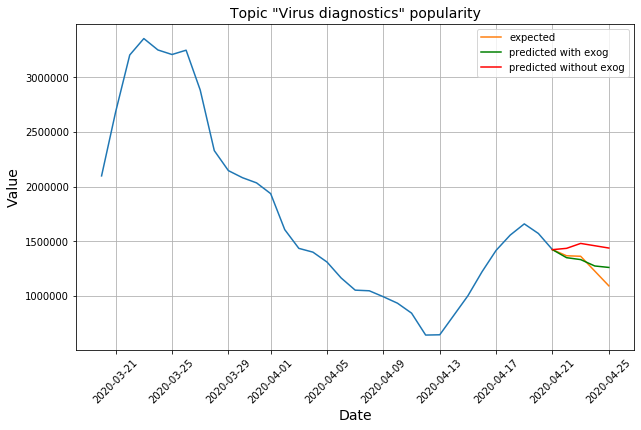

In [70]:
plt.figure(figsize=(10,6))
plt.plot(train_16)
plt.plot(new_index, test_list, label="expected")
plt.plot(new_index, predictions_1, color='green', label="predicted with exog")
plt.plot(new_index, predictions_2, color='red', label="predicted without exog")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Topic "Virus diagnostics" popularity', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [71]:
#####################################################################################################################

In [72]:
# TOPIC 8 - SALARY
test_size = 6
variable_8_title = 'sbj8_popularity_weighted'
variable_8 = stable_analysis_df[variable_8_title]

In [73]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(variable_8)[1])
print("Student test: p=%f" % stats.ttest_1samp(variable_8, 0)[1])

Dickey-Fuller test: p=0.069362
Student test: p=0.000000


In [74]:
diff_variable_8 = variable_8 - variable_8.shift(1)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(diff_variable_8[1:])[1])

Dickey-Fuller test: p=0.000000


In [75]:
variable_8_sub = pd.Series(gaussian_filter(variable_8, sigma=1)).to_frame().set_index([dates_index])[0]
train_8, test_data_8 = variable_8_sub[0:len(variable_8_sub)-test_size], variable_8_sub[len(variable_8_sub)-test_size:]

In [76]:
exog_titles = ['Confirmed_new_US', 'Deaths_new_US', 'work_US', 'transit_google_US', 'grocery_US'] 
exog = stable_analysis_df[exog_titles]
exog_train = exog[:len(exog) - test_size]
exog_test = exog[len(exog) - test_size:]

In [77]:
# SALARY 8 WITH EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_8.values, order=(param[0], d, param[1]), exog=exog_train).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 25
  parameters         aic
2     (0, 4)  878.085494
1     (0, 1)  886.777076
0     (0, 0)  906.455323


In [93]:
# SALARY 8 WITH EXOG TEST

# (0, 1, 4) - 6 test_size - 'Confirmed_new_US', 'Deaths_new_US', 'work_US', 'transit_google_US', 'grocery_US'] 
# (4, 1, 1) - 6 - 'Confirmed_new_US', 'Deaths_new_US', 'work_US', 'transit_google_US'
best_params = [(0, 1, 4)]
train_sets = [train_8]
test_sets = [test_data_8]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2]), exog=exog_train).fit()
    forecast = model_fit.forecast(steps=test_size, exog=exog_test)
    predictions_1 = list(forecast)[0]
    predictions_list.append(predictions_1)
    train_with_predicted = list(train_sets[i])
    for k in predictions_1:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_1[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 5.9130000
For 2 days prediction Test MAPE: 5.4040000
For 3 days prediction Test MAPE: 7.5400000
For 4 days prediction Test MAPE: 18.9110000
For 5 days prediction Test MAPE: 34.1110000
For 6 days prediction Test MAPE: 49.4850000


In [91]:
# SALARY 8 WITHOUT EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_8.values, order=(param[0], d, param[1])).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 25
  parameters         aic
4     (2, 1)  874.984360
3     (0, 4)  879.897049
2     (0, 2)  882.342703
1     (0, 1)  884.473980
0     (0, 0)  906.469553


In [92]:
# SALARY 8 WITHOUT EXOG TEST

 # (2, 1, 1) - 6 test_size
best_params = [(2, 1, 1)]
train_sets = [train_8]
test_sets = [test_data_8]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2])).fit()
    forecast = model_fit.forecast(steps=test_size)
    predictions_2 = list(forecast)[0]
    predictions_list.append(predictions_2)
    train_with_predicted = list(train_sets[i])
    for k in predictions_2:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_2[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 18.8110000
For 2 days prediction Test MAPE: 29.3670000
For 3 days prediction Test MAPE: 33.5960000
For 4 days prediction Test MAPE: 34.8970000
For 5 days prediction Test MAPE: 36.2350000
For 6 days prediction Test MAPE: 38.1430000


In [96]:
# PREPARE FOR PLOT SALARY 8 WITH/WITHOUT EXOG LISTS

last_value = list(train_8)[len(train_8) - 1]
test_list = list(test_data_8[:4])
test_list.insert(0, last_value)
predictions_1=np.insert(predictions_1[:4],0,last_value)
predictions_2=np.insert(predictions_2[:4],0,last_value)
new_index = pd.Index([train_8.index[-1]]).append(test_data_8[:4].index)

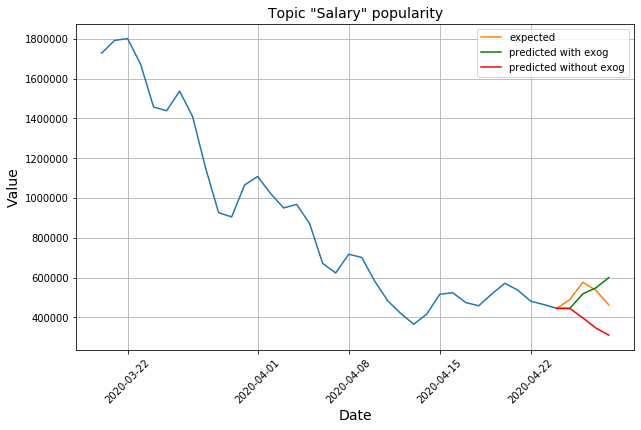

In [97]:
plt.figure(figsize=(10,6))
plt.plot(train_8)
plt.plot(new_index, test_list, label="expected")
plt.plot(new_index, predictions_1, color='green', label="predicted with exog")
plt.plot(new_index, predictions_2, color='red', label="predicted without exog")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Topic "Salary" popularity', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#####################################################################################################################

In [98]:
# TOPIC 3 - MUSIC
test_size = 6
variable_3_title = 'sbj3_engagement_weighted'
variable_3 = stable_analysis_df[variable_3_title]

In [99]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(variable_3)[1])
print("Student test: p=%f" % stats.ttest_1samp(variable_3, 0)[1]) 

Dickey-Fuller test: p=0.009291
Student test: p=0.000000


In [100]:
variable_3_sub = pd.Series(gaussian_filter(variable_3, sigma=1)).to_frame().set_index([dates_index])[0]
train_3, test_data_3 = variable_3_sub[0:len(variable_3_sub)-test_size], variable_3_sub[len(variable_3_sub)-test_size:]

In [101]:
exog_titles = ['Confirmed_new_US', 'Deaths_new_US', 'transit_google_US'] # 'work_US', 'grocery_US'
exog = stable_analysis_df[exog_titles]
exog_train = exog[:len(exog) - test_size]
exog_test = exog[len(exog) - test_size:]

In [102]:
# MUSIC 3 WITH EXOG TRAIN

ps = range(0, 5)
ds  = range(0, 3)
qs = range(0, 5)

parameters = product(ps, ds, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
train_sets = [train_3]
for train_set in train_sets:
    results = []
    best_aic = float("inf")
    for param in parameters_list:
        try:
            model = ARIMA(train_set.values, order=(param[0], param[1], param[2]), exog=exog_train).fit()
        except LinAlgError:
            continue
        except ValueError:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
            results.append([param, model.aic])
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 75
  parameters         aic
7  (0, 1, 4)  353.931126
6  (0, 1, 1)  354.480350
5  (0, 1, 0)  374.548643
4  (0, 0, 4)  419.610817
3  (0, 0, 3)  421.289944


In [103]:
# MUSIC 3 WITH EXOG TEST

best_params = [(0, 1, 4)]
train_sets = [train_3]
test_sets = [test_data_3]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2]), exog=exog_train).fit()
    forecast = model_fit.forecast(steps=test_size, exog=exog_test)
    predictions_1 = list(forecast)[0]
    predictions_list.append(predictions_1)
    train_with_predicted = list(train_sets[i])
    for k in predictions_1:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_1[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 1.0520000
For 2 days prediction Test MAPE: 5.1260000
For 3 days prediction Test MAPE: 3.8610000
For 4 days prediction Test MAPE: 4.2340000
For 5 days prediction Test MAPE: 5.3770000
For 6 days prediction Test MAPE: 5.2570000


In [104]:
# MUSIC 3 WITHOUT EXOG TRAIN

ps = range(0, 5)
ds  = range(0, 3)
qs = range(0, 5)

parameters = product(ps, ds, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
train_sets = [train_3]
for train_set in train_sets:
    results = []
    best_aic = float("inf")
    for param in parameters_list:
        try:
            model = ARIMA(train_set.values, order=(param[0], param[1], param[2])).fit()
        except LinAlgError:
            continue
        except ValueError:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
            results.append([param, model.aic])
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 75
   parameters         aic
10  (2, 2, 4)  348.823147
9   (0, 2, 3)  350.415418
8   (0, 2, 2)  350.810315
7   (0, 2, 1)  359.524543
6   (0, 1, 1)  359.878986


In [105]:
# MUSIC 3 WITHOUT EXOG TEST

best_params = [(2, 2, 4)]
train_sets = [train_3]
test_sets = [test_data_3]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2])).fit()
    forecast = model_fit.forecast(steps=test_size)
    predictions_2 = list(forecast)[0]
    predictions_list.append(predictions_2)
    train_with_predicted = list(train_sets[i])
    for k in predictions_2:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_2[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 7.8640000
For 2 days prediction Test MAPE: 12.1790000
For 3 days prediction Test MAPE: 10.6710000
For 4 days prediction Test MAPE: 9.2060000
For 5 days prediction Test MAPE: 8.2680000
For 6 days prediction Test MAPE: 9.0890000


In [106]:
# PREPARE FOR PLOT MUSIC 3 WITH/WITHOUT EXOG LISTS

last_value = list(train_3)[len(train_3) - 1]
test_list = list(test_data_3)
test_list.insert(0, last_value)
predictions_1=np.insert(predictions_1,0,last_value)
predictions_2=np.insert(predictions_2,0,last_value)
new_index = pd.Index([train_3.index[-1]]).append(test_data_3.index)

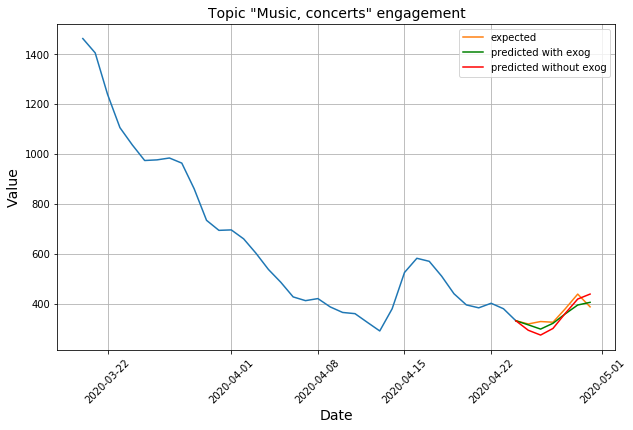

In [107]:
plt.figure(figsize=(10,6))
plt.plot(train_3)
plt.plot(new_index, test_list, label="expected")
plt.plot(new_index, predictions_1, color='green', label="predicted with exog")
plt.plot(new_index, predictions_2, color='red', label="predicted without exog")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Topic "Music, concerts" engagement', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#####################################################################################################################

In [ ]:
# TOPIC 5 - FINANCE
test_size = 7
variable_5_title = 'sbj5_engagement_weighted'
variable_5 = stable_analysis_df[variable_5_title]

In [ ]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(variable_5)[1])
print("Student test: p=%f" % stats.ttest_1samp(variable_5, 0)[1]) 

In [ ]:
diff_variable_5 = variable_5 - variable_5.shift(1)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(diff_variable_5[1:])[1])

In [ ]:
variable_5_sub = pd.Series(gaussian_filter(variable_5, sigma=1)).to_frame().set_index([dates_index])[0]
train_5, test_data_5 = variable_5_sub[0:len(variable_5_sub)-test_size], variable_5_sub[len(variable_5_sub)-test_size:]

In [ ]:
exog_titles = ['Confirmed_new_US', 'Deaths_new_US', 'transit_google_US', 'work_US'] 
exog = stable_analysis_df[exog_titles]
exog_train = exog[:len(exog) - test_size]
exog_test = exog[len(exog) - test_size:]

In [ ]:
# FINANCE 5 WITH EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_5.values, order=(param[0], d, param[1]), exog=exog_train).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
# FINANCE 5 WITH EXOG TEST

best_params = [(0, 1, 2)]
train_sets = [train_5]
test_sets = [test_data_5]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2]), exog=exog_train).fit()
    forecast = model_fit.forecast(steps=test_size, exog=exog_test)
    predictions_1 = list(forecast)[0]
    predictions_list.append(predictions_1)
    train_with_predicted = list(train_sets[i])
    for k in predictions_1:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_1[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

In [ ]:
# FINANCE 5 WITHOUT EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_5.values, order=(param[0], d, param[1])).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
# FINANCE 5 WITHOUT EXOG TEST

best_params = [(2, 1, 3)]
train_sets = [train_5]
test_sets = [test_data_5]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2])).fit()
    forecast = model_fit.forecast(steps=test_size)
    predictions_2 = list(forecast)[0]
    predictions_list.append(predictions_2)
    train_with_predicted = list(train_sets[i])
    for k in predictions_2:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_2[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

In [ ]:
# PREPARE FOR PLOT FINANCE 5 WITH/WITHOUT EXOG LISTS

last_value = list(train_5)[len(train_5) - 1]
test_list = list(test_data_5[:4])
test_list.insert(0, last_value)
predictions_1=np.insert(predictions_1[:4],0,last_value)
predictions_2=np.insert(predictions_2[:4],0,last_value)
new_index = pd.Index([train_5.index[-1]]).append(test_data_5[:4].index)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_5)
plt.plot(new_index, test_list, label="expected")
plt.plot(new_index, predictions_1, color='green', label="predicted with exog")
plt.plot(new_index, predictions_2, color='red', label="predicted without exog")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Topic "Finance" engagement', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#####################################################################################################################

In [108]:
# TOPIC 2 - Covid-19 in New York
test_size = 8
variable_9_title = 'sbj2_popularity_weighted'
variable_9 = stable_analysis_df[variable_9_title]

In [109]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(variable_9)[1])
print("Student test: p=%f" % stats.ttest_1samp(variable_9, 0)[1]) 

Dickey-Fuller test: p=0.341890
Student test: p=0.000000


In [110]:
diff_variable_9 = variable_9 - variable_9.shift(1)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(diff_variable_9[1:])[1])

Dickey-Fuller test: p=0.000000


In [111]:
variable_9_sub = pd.Series(gaussian_filter(variable_9, sigma=1)).to_frame().set_index([dates_index])[0]
train_9, test_data_9 = variable_9_sub[0:len(variable_9_sub)-test_size], variable_9_sub[len(variable_9_sub)-test_size:]

In [112]:
exog_titles = ['Confirmed_new_US', 'Deaths_new_US', 'work_US'] 
exog = stable_analysis_df[exog_titles]
exog_train = exog[:len(exog) - test_size]
exog_test = exog[len(exog) - test_size:]

In [113]:
# Covid-19 in New York 2 WITH EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_9.values, order=(param[0], d, param[1]), exog=exog_train).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 25
  parameters         aic
2     (0, 2)  781.699158
1     (0, 1)  786.981328
0     (0, 0)  814.110789


In [114]:
# Covid-19 in New York 2 WITH EXOG TEST
# 7 - (0, 1, 3)
best_params = [(0, 1, 2)]
train_sets = [train_9]
test_sets = [test_data_9]
predictions_list = []
for i in range(len(train_sets)):
    model_fit=ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2]), exog=exog_train).fit()
    forecast = model_fit.forecast(steps=test_size, exog=exog_test)
    predictions_1 = list(forecast)[0]
    predictions_list.append(predictions_1)
    train_with_predicted = list(train_sets[i])
    for k in predictions_1:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_1[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 3.4600000
For 2 days prediction Test MAPE: 3.3590000
For 3 days prediction Test MAPE: 2.3810000
For 4 days prediction Test MAPE: 4.1330000
For 5 days prediction Test MAPE: 7.4400000
For 6 days prediction Test MAPE: 10.8100000
For 7 days prediction Test MAPE: 12.7360000
For 8 days prediction Test MAPE: 12.4680000


In [115]:
# Covid-19 in New York 2 WITHOUT EXOG TRAIN

ps = range(0, 5)
d  = 1
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(train_9.values, order=(param[0], d, param[1])).fit()
    except LinAlgError:
        continue
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Number of analysed models: 25
  parameters         aic
2     (0, 2)  774.988686
1     (0, 1)  782.171164
0     (0, 0)  810.453276


In [116]:
# Covid-19 in New York 2 WITHOUT EXOG TEST

best_params = [(0, 1, 3)]
train_sets = [train_9]
test_sets = [test_data_9]
predictions_list = []
for i in range(len(train_sets)):
    model_fit = ARIMA(train_sets[i].values, order=(best_params[i][0], best_params[i][1], best_params[i][2])).fit()
    forecast = model_fit.forecast(steps=test_size)
    predictions_2 = list(forecast)[0]
    predictions_list.append(predictions_2)
    train_with_predicted = list(train_sets[i])
    for k in predictions_2:
        train_with_predicted.append(k)
    test_real = test_sets[i]
    for j in range(1, len(test_sets[i]) + 1):
        test_lag = j
        t_mape = mape(test_real[:test_lag], predictions_2[:test_lag])
        print('For %d days prediction Test MAPE: %.7f' % (j, t_mape))

For 1 days prediction Test MAPE: 0.6840000
For 2 days prediction Test MAPE: 3.8530000
For 3 days prediction Test MAPE: 8.5900000
For 4 days prediction Test MAPE: 14.1860000
For 5 days prediction Test MAPE: 20.3100000
For 6 days prediction Test MAPE: 26.5180000
For 7 days prediction Test MAPE: 32.0370000
For 8 days prediction Test MAPE: 36.7530000


In [117]:
# PREPARE FOR PLOT Covid-19 in New York 2 WITH/WITHOUT EXOG LISTS

last_value = list(train_9)[len(train_9) - 1]
test_list = list(test_data_9)
test_list.insert(0, last_value)
predictions_1=np.insert(predictions_1,0,last_value)
predictions_2=np.insert(predictions_2,0,last_value)
new_index = pd.Index([train_9.index[-1]]).append(test_data_9.index)

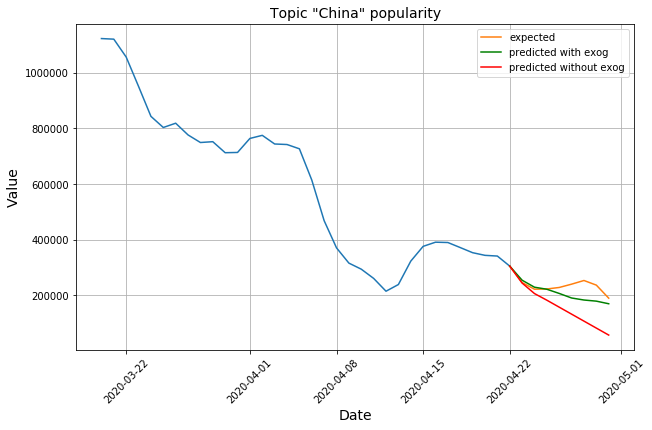

In [118]:
plt.figure(figsize=(10,6))
plt.plot(train_9)
plt.plot(new_index, test_list, label="expected")
plt.plot(new_index, predictions_1, color='green', label="predicted with exog")
plt.plot(new_index, predictions_2, color='red', label="predicted without exog")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Topic "China" popularity', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()